In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, ZeroPadding2D, Add, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Semantic/
!ls

/content/drive/MyDrive/Semantic
Augmented  CXR_png  masks  ResNet50Aug.h5  ResNet50.h5


In [4]:
mask_path = "./Augmented/Masks/"
train_path = "./Augmented/Images/"

mask_ids = next(os.walk(mask_path))[2]
masks = [os.path.join(mask_path, f"{name}") for name in mask_ids]
train_ids = next(os.walk(train_path))[2]
train = [os.path.join(train_path, f"{name}") for name in train_ids]

In [5]:
print(len(train))
print(len(masks))

1263
1263


In [6]:
train = sorted(train)
masks = sorted(masks)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, masks, test_size=0.2, random_state=42)
print(len(x_train), len(x_test), len(y_train), len(y_test))

1010 253 1010 253


In [8]:
def read_image(x, W=1024, H=1024):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def preprocess(x, y, W=1024, H=1024):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        
        image = read_image(x)
        mask = read_image(y)
        return image, mask
    image, mask = tf.numpy_function(f, [x,y], [tf.float32,tf.float32])
    image.set_shape([H,W,1])
    mask.set_shape([H,W,1])
    return image, mask

In [9]:
def tf_dataset(x,y,batch_size=1):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    #data = data.shuffle(buffer_size=5000)
    data = data.map(preprocess)
    data = data.batch(batch_size)
    data = data.repeat()
    data = data.prefetch(2)
    return data

In [10]:
train_dataset = tf_dataset(x_train,y_train)
test_dataset = tf_dataset(x_test, y_test)

In [11]:
print(train_dataset)

<PrefetchDataset shapes: ((None, 1024, 1024, 1), (None, 1024, 1024, 1)), types: (tf.float32, tf.float32)>


In [12]:
def read2rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

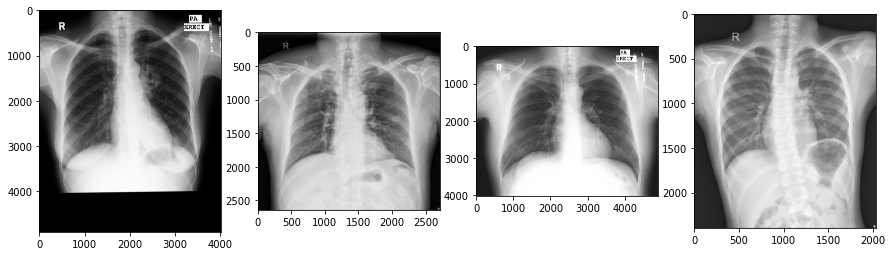

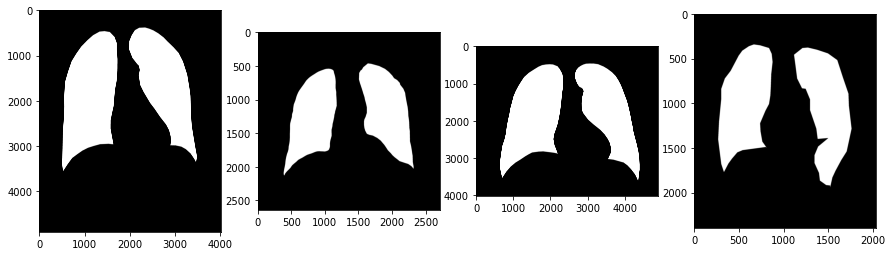

In [13]:
train_x = train
train_y = masks

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,4,1)
imgplot = plt.imshow(read2rgb(train_x[6]))

a = fig.add_subplot(1,4,2)
imgplot = plt.imshow(read2rgb(train_x[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,4,3)
imgplot = plt.imshow(read2rgb(train_x[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,4,4)
imgplot = plt.imshow(read2rgb(train_x[15]))
imgplot.set_clim(0.0,2.1)

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,4,1)
imgplot = plt.imshow(read2rgb(train_y[6]))

a = fig.add_subplot(1,4,2)
imgplot = plt.imshow(read2rgb(train_y[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,4,3)
imgplot = plt.imshow(read2rgb(train_y[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,4,4)
imgplot = plt.imshow(read2rgb(train_y[15]))
imgplot.set_clim(0.0,2.1)

In [14]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
   
    conv = Conv2D(n_filters,3, activation='relu',padding='same',kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3,activation='relu',padding='same',kernel_initializer='HeNormal')(conv)
    
    if dropout_prob > 0:
        layer = tf.keras.layers.Dropout(dropout_prob, input_shape = (2,))
        conv = layer(conv, training = True)
    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
       
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [15]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,3,strides=(2,2),padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,3, activation='relu',padding='same',kernel_initializer='HeNormal')(conv)
    return conv

In [37]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob = 0.3) 
    
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob = 0.3, max_pooling=False) 
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    
    conv9 = Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes,1, padding='same')(conv9)
    out = Activation(activation="softmax")(conv10)
    model = tf.keras.Model(inputs=inputs, outputs=out)

    return model

In [38]:
net = unet_model((1024,1024,1))
net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 1024, 1024, 3 320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 1024, 1024, 3 9248        conv2d_80[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 512, 512, 32) 0           conv2d_81[0][0]                  
____________________________________________________________________________________________

In [18]:
smooth = 1e-15

def dice_coefficent(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2*intersection + smooth)/ (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def loss(y_true, y_pred):
    return 1 - dice_coefficent(y_true, y_pred)

In [19]:
lr = 1e-4
opt = tf.keras.optimizers.Adam(lr)
metrics = [dice_coefficent, Recall(), Precision()]

In [20]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [21]:
def create_mask(pred_mask):
  res = pred_mask[-1,:,:]
  res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  return res

In [22]:
def show_predictions(dataset=None, num=1):
  if train_dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = net.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(net.predict(sample_image[tf.newaxis, ...]))])

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [25]:
callbacks = [
    ModelCheckpoint("./UNetAug.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1),
    DisplayCallback()
]

In [ ]:
net = tf.keras.models.load_model('./UNetAug.h5', custom_objects={'dice_coefficent':dice_coefficent, 'loss':loss})

In [39]:
net.compile(loss=loss,optimizer=opt, metrics=metrics)

In [27]:
from IPython.display import clear_output

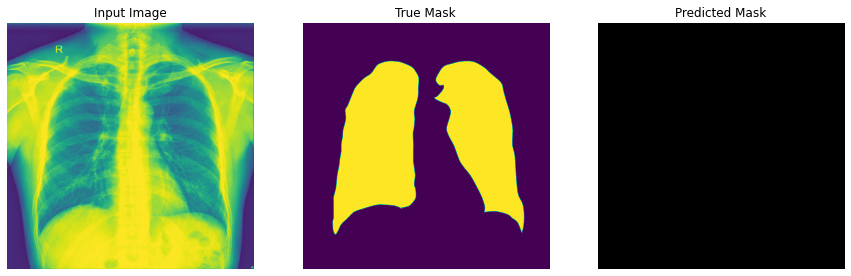


Sample Prediction after epoch 6

Epoch 00006: early stopping


In [40]:
history = net.fit(
    train_dataset,
    steps_per_epoch=len(x_train),
    epochs=10,
    callbacks=callbacks, 
    validation_data=test_dataset, 
    validation_steps=len(x_test)
  )

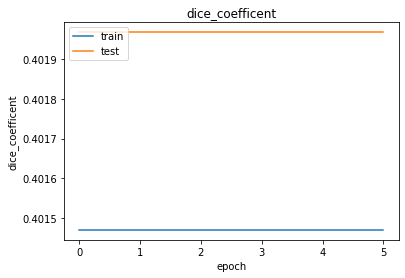

In [41]:
plt.plot(history.history['dice_coefficent'])
plt.plot(history.history['val_dice_coefficent'])
plt.title('dice_coefficent')
plt.ylabel('dice_coefficent')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

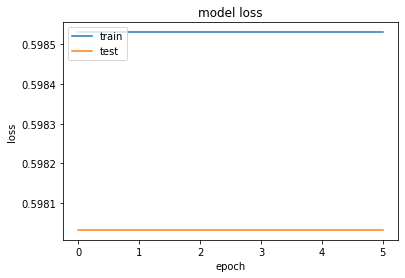

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

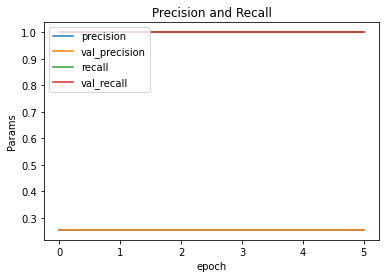

In [43]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Precision and Recall')
plt.ylabel('Params')
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision', 'recall', 'val_recall'], loc='upper left')
plt.show()

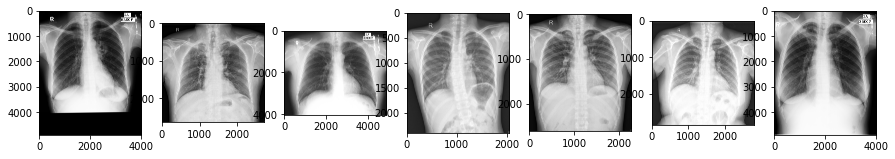

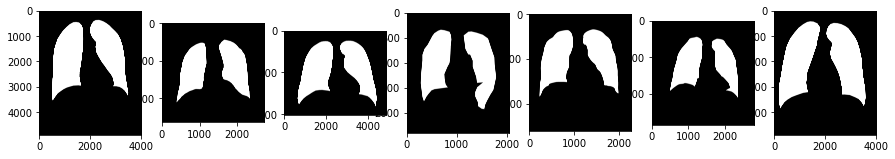

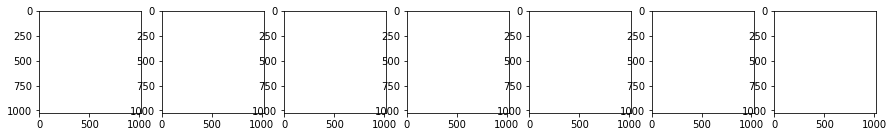

In [44]:
fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,7,1)
imgplot = plt.imshow(read2rgb(train_x[6]))

a = fig.add_subplot(1,7,2)
imgplot = plt.imshow(read2rgb(train_x[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,7,3)
imgplot = plt.imshow(read2rgb(train_x[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,7,4)
imgplot = plt.imshow(read2rgb(train_x[15]))
imgplot.set_clim(0.0,2.1)

a = fig.add_subplot(1,7,5)
imgplot = plt.imshow(read2rgb(train_x[2]))

a = fig.add_subplot(1,7,6)
imgplot = plt.imshow(read2rgb(train_x[4]))

a = fig.add_subplot(1,7,7)
imgplot = plt.imshow(read2rgb(train_x[7]))

fig = plt.figure(figsize=(15,15))

a = fig.add_subplot(1,7,1)
imgplot = plt.imshow(read2rgb(train_y[6]))

a = fig.add_subplot(1,7,2)
imgplot = plt.imshow(read2rgb(train_y[10]))
imgplot.set_clim(0.0,0.7)

a = fig.add_subplot(1,7,3)
imgplot = plt.imshow(read2rgb(train_y[8]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,7,4)
imgplot = plt.imshow(read2rgb(train_y[15]))
imgplot.set_clim(0.0,1.4)

a = fig.add_subplot(1,7,5)
imgplot = plt.imshow(read2rgb(train_y[2]))
imgplot.set_clim(0.0,2.1)

a = fig.add_subplot(1,7,6)
imgplot = plt.imshow(read2rgb(train_y[4]))
imgplot.set_clim(0.0,2.1)

a = fig.add_subplot(1,7,7)
imgplot = plt.imshow(read2rgb(train_y[7]))
imgplot.set_clim(0.0,2.1)

fig = plt.figure(figsize=(15,15))

img = read_image(train_x[6])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,1)
imgplot = plt.imshow(res)

img = read_image(train_x[10])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,2)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,0.7)

img = read_image(train_x[8])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,3)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,1.4)


img = read_image(train_x[15])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,4)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)

img = read_image(train_x[2])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,5)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)

img = read_image(train_x[4])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,6)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)

img = read_image(train_x[7])
img = np.expand_dims(img, axis=0)
res = net.predict(img)
res = res[-1,:,:]
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
a = fig.add_subplot(1,7,7)
imgplot = plt.imshow(res)
imgplot.set_clim(0.0,2.1)